## 송재환 클로젯셰어 분석 👕👚
- 클로젯셰어 신규 구매 전반 분석 및 결과 도식화
- 분석 자료: 최근 3개월간 신규 구매 데이터 일부

## 세팅 및 데이터 클렌징

### 모듈 Import

In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style="white")
plt.rc('font', family='AppleGothic') 
# plt.rc('font', family='Malgun Gothic') 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.unicode_minus'] = False    # minus

# interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 노트북 세팅
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

# 연관분석
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Data import

***과제 데이터***

In [2]:
# 과제 data
closet = pd.read_excel('클로젯셰어_과제DB 대체 자료.xlsx',)
df = closet.copy()
# col > lower
df.columns=list(map(lambda x: x.lower(),df.columns))

In [3]:
df = df.sort_values(['order_date','user']).reset_index(drop=True)

In [4]:
# 가입 정보 관련 날짜 변수 추가 
df['reg_date']=pd.to_datetime(df['reg_date'])
df['reg_year']=df['reg_date'].dt.strftime('%Y')
df['reg_month']=df['reg_date'].dt.strftime('%m')
df['reg_yearmonth']=df['reg_date'].dt.strftime('%Y-%m')
df['reg_dayofweek']=df['reg_date'].dt.dayofweek
df['order_month']=df['order_date'].dt.month
df['order_week']=df['order_date'].dt.week
df['order_dayofweek']=df['order_date'].dt.dayofweek
# date continuous변환
df['order_date']=pd.to_datetime(df['order_date']).dt.date
df['reg_date']=pd.to_datetime(df['reg_date']).dt.date

In [5]:
# 2021 top 10 list
luxury_list=['GUCCI','Louis Vuitton','Cartier','Chanel','Hermes','Ferrari','Rolex','Dior','Christian Dior','COACH','Estee Lauder','Tiffany & Co.',
'Guerlain','Burberry','Prada','Lancôme','Omega','Clarins','Bulgari','Moncler','Saint Laurent','SK-II','McLaren','TAG Heuer','Givenchy','Lamborghini','Armani','Bottega Veneta','Rolls- Royce',
'Bentley','Aston Martin','Loewe','Maserati','Van Cleef & Arpels','Valentino','Salvatore Ferragamo','Shiseido','Sulwhasoo','Tissot','Versace','Bobbi Brown','Montblanc','Tom Ford','Longines','Cle de Peau Beaute','Jaeger-LeCoultre',
'Celine','Dolce & Gabbana','Miu Miu','Fendi']
# brandnm luxury 
df['brandnm_luxury']=np.where(df['brandnm'].isin(luxury_list), 1,0)
df.head()

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,5.00,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y,2020,04,2020-04,4.00,1,53,4,0
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,NaN,2020,12,2020-12,3.00,1,53,5,0


***외부 데이터***

In [6]:
# 크롤링 data 가격정보
price = pd.read_excel('tag_price_df.xlsx')
# remove space
price.columns=list(map(lambda x: x.replace(' ',''),price.columns))

### 데이터 개요

In [7]:
df.head(5)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,5.00,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y,2020,04,2020-04,4.00,1,53,4,0
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,NaN,2020,12,2020-12,3.00,1,53,5,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brandnm          1442 non-null   object 
 1   goodsnm          1471 non-null   object 
 2   user             1471 non-null   object 
 3   reg_date         1466 non-null   object 
 4   order_date       1471 non-null   object 
 5   p_type           1471 non-null   object 
 6   sub_type         1471 non-null   object 
 7   app_yn           1295 non-null   object 
 8   reg_year         1466 non-null   object 
 9   reg_month        1466 non-null   object 
 10  reg_yearmonth    1466 non-null   object 
 11  reg_dayofweek    1466 non-null   float64
 12  order_month      1471 non-null   int64  
 13  order_week       1471 non-null   int64  
 14  order_dayofweek  1471 non-null   int64  
 15  brandnm_luxury   1471 non-null   int64  
dtypes: float64(1), int64(4), object(11)
memory usage: 184.0+ KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
reg_dayofweek,1466.00,2.71,1.98,0.00,1.00,2.00,4.00,6.00
order_month,1471.00,2.18,0.81,1.00,1.00,2.00,3.00,3.00
order_week,1471.00,7.88,5.28,1.00,5.00,8.00,11.00,53.00
order_dayofweek,1471.00,2.39,1.68,0.00,1.00,2.00,3.00,6.00
brandnm_luxury,1471.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00


In [10]:
price.tail() # 가격 데이터 전처리 : 쉼표 제거 필요, tag # 제거

,brand2,product2,tag1,tag2,tag3,tag4,4일가격,7일가격
367,Prada,color strap shoulder bag navy,#오피스,NaN,NaN,NaN,"39,000원\n7일","49,000원"
368,Chloe,drew bag beige,#오피스,#위켄드,NaN,NaN,"39,000원\n7일","49,000원"
369,Maison Margiela,Bucket black bag,#일상,NaN,NaN,NaN,"39,000원\n7일","49,000원"
370,Dior,croisiere patent lady bag navy,#위켄드,NaN,NaN,NaN,"49,000원\n7일","59,000원"
371,Gucci,vintage web GG two way bag brown,#오피스,NaN,NaN,NaN,"49,000원\n7일","59,000원"


In [11]:
price['7일가격'].unique()

array(['59,000원', '44,000원', '49,000원', nan, '69,000원', ']'], dtype=object)

In [12]:
price.describe().T

,count,unique,top,freq
brand2,372,25,Gucci,118
product2,372,137,luggage bag black,8
tag1,334,6,#오피스,186
tag2,166,6,#위켄드,76
tag3,24,3,#파티,10
tag4,4,1,#포멀이벤트,4
4일가격,368,4,"49,000원\n7일",192
7일가격,368,5,"59,000원",191


### 데이터 정리

In [13]:
print('브랜드 수:', df.brandnm.nunique())
brand_list=df.brandnm.value_counts().index.unique()
print('브랜드 리스트: ', brand_list, '\n')
print('유저 수:', df.user.nunique(),'\n')
print('구매 타입 수:', df.p_type.nunique())
print('구매 타입 수:', df.p_type.unique(),'\n')
print('서브 타입 수:', df.sub_type.nunique())
print('서브 타입 수:', df.sub_type.unique(),'\n')
print('제품 수: ', df.goodsnm.nunique(),'\n')
print('가입 정보 기간:', pd.to_datetime(df['reg_date']).min() ,"~", pd.to_datetime(df['reg_date']).max())
print('구매 정보 기간:', df.order_date.min() ,"~", df.order_date.max())

브랜드 수: 245
브랜드 리스트:  Index(['Gucci', 'Chanel', 'Saint Laurent', 'Louis Vuitton', 'Prada',
       'Burberry', 'Yves Saint Laurent', 'Thom Browne', 'Fendi', 'Celine',
       ...
       'London Fog', 'OiOi', 'Burberry Brit', 'Nice Claup', 'Salon De yohn',
       'SJYP', 'Collabotory', 'Ami', 'A BY A', 'Leah'],
      dtype='object', length=245) 

유저 수: 1234 

구매 타입 수: 2
구매 타입 수: ['7days' '4days'] 

서브 타입 수: 6
서브 타입 수: ['O' 'D' 'BA' 'T' 'B' 'TP'] 

제품 수:  979 

가입 정보 기간: 2017-06-24 00:00:00 ~ 2021-03-31 00:00:00
구매 정보 기간: 2021-01-01 ~ 2021-03-31


### 결측치 확인 및 처리

In [14]:
df.isnull().sum()

brandnm             29
goodsnm              0
user                 0
reg_date             5
order_date           0
p_type               0
sub_type             0
app_yn             176
reg_year             5
reg_month            5
reg_yearmonth        5
reg_dayofweek        5
order_month          0
order_week           0
order_dayofweek      0
brandnm_luxury       0
dtype: int64

**brandnm : fillna('N/A')**

In [15]:
df['brandnm'] = df['brandnm'].fillna('N/A')

**app_yn : fillna(0)**

In [16]:
# app_yn 값 0, 1 치환
df['app_yn'] = df['app_yn'].fillna(0)
df.loc[(df.app_yn == 'Y'), 'app_yn'] = 1

**reg_date : fillna(method='pad')**

In [17]:
# reg_date 순서대로 user의 id가 부여되었는지 확인
reg_user = df[df['reg_date'].notnull()].sort_values('user').sort_values('reg_date').reset_index().iloc[:,3:5]
print(reg_user)

for i in np.arange(0,len(reg_user)-1):
    if int(reg_user.user[i][1:]) > int(reg_user.user[i+1][1:]):
        
        if reg_user.reg_date[i] != reg_user.reg_date[i+1]:
            print("순서대로 부여되지 않았습니다.")

print("")
print("user의 id는 reg_date의 순서대로 부여되었다.")

          user    reg_date
0       a11612  2017-06-24
1       a11803  2017-07-02
2       a13637  2018-03-09
3       a13741  2018-03-20
4       a13934  2018-03-27
...        ...         ...
1461  a1151479  2021-03-31
1462  a1151481  2021-03-31
1463  a1151496  2021-03-31
1464  a1151499  2021-03-31
1465  a1151564  2021-03-31

[1466 rows x 2 columns]

user의 id는 reg_date의 순서대로 부여되었다.


In [18]:
# 바로 앞 유저의 날짜를 임의 부여
df['reg_date'] = df['reg_date'].fillna(method = 'pad')

## EDA

### user별 구매일 확인
- user당 order_date는 하루 뿐이다. 

In [19]:
# user가 order_date에 1:1 대응되는 모습
print("고유 user 수: ", len(df['user'].unique()))
df.groupby('user')['order_date'].value_counts().sort_values(ascending=False)

고유 user 수:  1234


user      order_date
a1149461  2021-03-17    11
a1149583  2021-03-19    10
a1142677  2021-01-18     9
a1143701  2021-01-22     7
a189404   2021-03-24     7
                        ..
a1148750  2021-03-09     1
a1148768  2021-03-12     1
a1148769  2021-03-17     1
a1148775  2021-03-12     1
a1146892  2021-02-26     1
Name: order_date, Length: 1234, dtype: int64

### user별 구매 건수 확인
- 구매 건수가 1건인 user가 압도적으로 많다.
- 최대 구매 건수는 11건

In [20]:
df.groupby('user')['order_date'].count().sort_values()

user
a1146892     1
a1148775     1
a1148769     1
a1148768     1
a1148750     1
            ..
a189404      7
a1143701     7
a1142677     9
a1149583    10
a1149461    11
Name: order_date, Length: 1234, dtype: int64

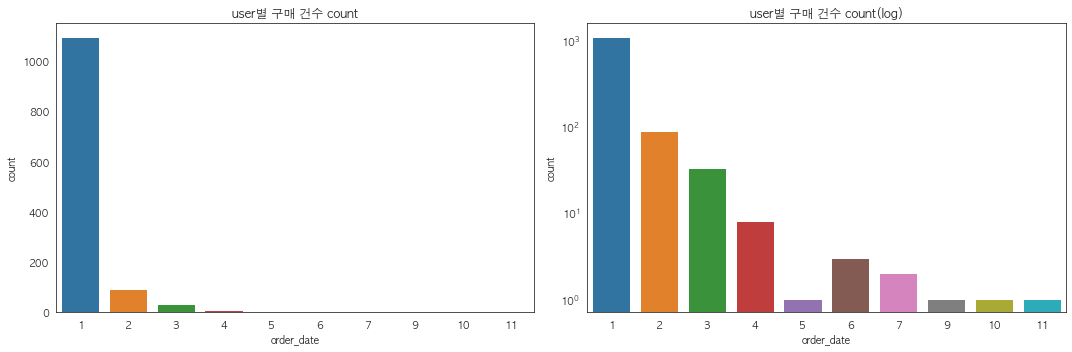

In [21]:
figure, ax_list_list = plt.subplots(nrows=1, ncols=2);
figure.set_size_inches(15,5)
ax_list = ax_list_list.reshape(2)

sns.countplot(df.groupby('user')['order_date'].count().sort_values(), ax=ax_list[0])
ax_list[0].set_title("user별 구매 건수 count")
sns.countplot(df.groupby('user')['order_date'].count().sort_values(), log=True, ax=ax_list[1])
ax_list[1].set_title("user별 구매 건수 count(log)")

plt.tight_layout()

### df_user 기본 정보 테이블 생성 (column 별 count)
- 세부적인 분석을 위해 user 정보를 더 자세히 살펴본다.

In [22]:
# df_user 유저 기본 정보 테이블생성
df_user = df.groupby(['user','reg_date','reg_yearmonth','order_date','order_month','order_week','order_dayofweek'])['goodsnm'].count().to_frame().reset_index().rename(columns={'goodsnm':'order_count'}) 
ptype = df.pivot_table(index='user', columns='p_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
subtype = df.pivot_table(index='user', columns='sub_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
app = df.pivot_table(index='user', columns='app_yn',values= 'order_date',aggfunc='count').fillna(0).reset_index().rename(columns={'Y':'app'}) 

# merge
df_user = df_user.merge(ptype, how='left', on='user').merge(app, how='left', on='user').merge(subtype, how='left', on='user').fillna(0)
df_user.head(5)

,user,reg_date,reg_yearmonth,order_date,order_month,order_week,order_dayofweek,order_count,4days,7days,0,1,B,BA,D,O,T,TP
0,a1100548,2020-05-16,2020-05,2021-03-31,3,13,2,2,2.00,0.00,0.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00
1,a1100887,2020-05-19,2020-05,2021-03-29,3,13,0,1,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
2,a1101514,2020-05-25,2020-05,2021-02-05,2,5,4,1,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
3,a1101645,2020-05-26,2020-05,2021-02-23,2,8,1,1,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,a1102068,2020-05-29,2020-05,2021-03-04,3,9,3,1,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00


### user segment 분류
- 가입일 기준, 2021년 이후 가입자는 신규 유저(1), 이전 가입자는 기존 유저(0)로 구분
- 구매 건수 기준, 2건 이상 구매 건수의 유저는 heavy user(1), 1건만 구매한 유저는 normal user(0)로 구분

In [23]:
# 신규 및 기존 유저 정보 추가
new_list = df_user.query('(reg_yearmonth=="2021-01") |(reg_yearmonth=="2021-02")|(reg_yearmonth=="2021-03")').user.tolist()
df_user['seg_new'] = np.where(df_user.user.isin(new_list), 1, 0)

In [24]:
df_user.describe().T

,count,mean,std,min,25%,50%,75%,max
order_month,1229.00,2.19,0.81,1.00,1.00,2.00,3.00,3.00
order_week,1229.00,7.93,5.23,1.00,5.00,8.00,11.00,53.00
order_dayofweek,1229.00,2.39,1.67,0.00,1.00,2.00,3.00,6.00
order_count,1229.00,1.19,0.73,1.00,1.00,1.00,1.00,11.00
4days,1229.00,0.73,0.90,0.00,0.00,1.00,1.00,11.00
7days,1229.00,0.47,0.62,0.00,0.00,0.00,1.00,6.00
0,1229.00,0.14,0.59,0.00,0.00,0.00,0.00,11.00
1,1229.00,1.05,0.69,0.00,1.00,1.00,1.00,9.00
B,1229.00,0.05,0.30,0.00,0.00,0.00,0.00,6.00
BA,1229.00,0.56,0.50,0.00,0.00,1.00,1.00,2.00


In [25]:
# 구매 건수의 상위 25%까지도 구매 건수가 1건이기 때문에 2건 이상이면 heavy user로 규정
heavy_list=df_user.query('order_count > 1').user.tolist()
df_user['seg_heavy']=np.where(df_user.user.isin(heavy_list),1,0)

In [26]:
df_user.head(5)

,user,reg_date,reg_yearmonth,order_date,order_month,order_week,order_dayofweek,order_count,4days,7days,0,1,B,BA,D,O,T,TP,seg_new,seg_heavy
0,a1100548,2020-05-16,2020-05,2021-03-31,3,13,2,2,2.00,0.00,0.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0,1
1,a1100887,2020-05-19,2020-05,2021-03-29,3,13,0,1,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0,0
2,a1101514,2020-05-25,2020-05,2021-02-05,2,5,4,1,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0
3,a1101645,2020-05-26,2020-05,2021-02-23,2,8,1,1,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0,0
4,a1102068,2020-05-29,2020-05,2021-03-04,3,9,3,1,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0,0


In [27]:
# 컬럼 차이 비율 계산 함수
def diff_rate(segment, col_name, g_col):
    q = segment
    q0 = q + ' == ' + str(0)
    q1 = q + ' == ' + str(1)

    diff_rate_oldnew = pd.merge(pd.DataFrame(df_seg.query(q0).groupby(g_col)['user'].count()).reset_index(g_col).rename(columns = {'user':'old_count'}),
             pd.DataFrame(df_seg.query(q1).groupby(g_col)['user'].count()).reset_index(g_col).rename(columns = {'user':'new_count'}),
             on=g_col, how='inner').set_index(g_col).pct_change(axis='columns').sort_values(by='new_count', ascending=False).rename(columns={'new_count': col_name}).drop(columns = ['old_count'])
    diff_rate_df = diff_rate_oldnew.loc[list(df_seg.query(q1).groupby(g_col)['user'].count().sort_values(ascending = False).head(10).index),:]
    return diff_rate_df

### user segment별 서비스 이용 경향 확인
1. 브랜드
2. 서브 카테고리
3. 제품 특징
4. 앱 이용 및 이용권

In [28]:
# user_seg 정보를 df에 활용
df_seg = pd.merge(df, df_user, on='user', how='left')
df_seg.rename(columns={'reg_date_x':'reg_date',
                       'order_date_x':'order_date',
                       'reg_yearmonth_x':'reg_yearmonth',
                       'order_month_x':'order_month',
                       'order_week_x':'order_week',
                       'order_dayofweek_x':'order_dayofweek'}, inplace=True)

#### user segment별 브랜드 이용 경향
- user segment와 관계 없이 Gucci의 구매 건수가 가장 많은 것을 확인할 수 있다.
- old user들이 주로 구매하던 브랜드를 new user들도 대부분 이용하며, 보다 많이 이용하는 것을 확인할 수 있다.
----
- normal user의 경우 Gucci, Chanel, Saint Laurent, Louis Vuitton의 구매 빈도가 높은 반면,<br>heavy user는 여러 브랜드를 골고루 이용하는 것을 확인할 수 있다.
- heavy user들은 normal user들이 주로 이용하는 브랜드 대부분을 이용하지 않고,<br>'El estilo de Claire'나 'Vivien westwood'와 같은 브랜드를 추가로 이용하고 있다.
----
***&#10145; 21년 가입한 이용자들의 구매 건수가 증가했으며, user들의 선호가 대중적인 하이엔드 브랜드에 맞춰져 있음을 알 수 있다.<br>여러 제품을 한번에 구매하는 user들은 선호하는 브랜드 양상이 조금 다르다.***

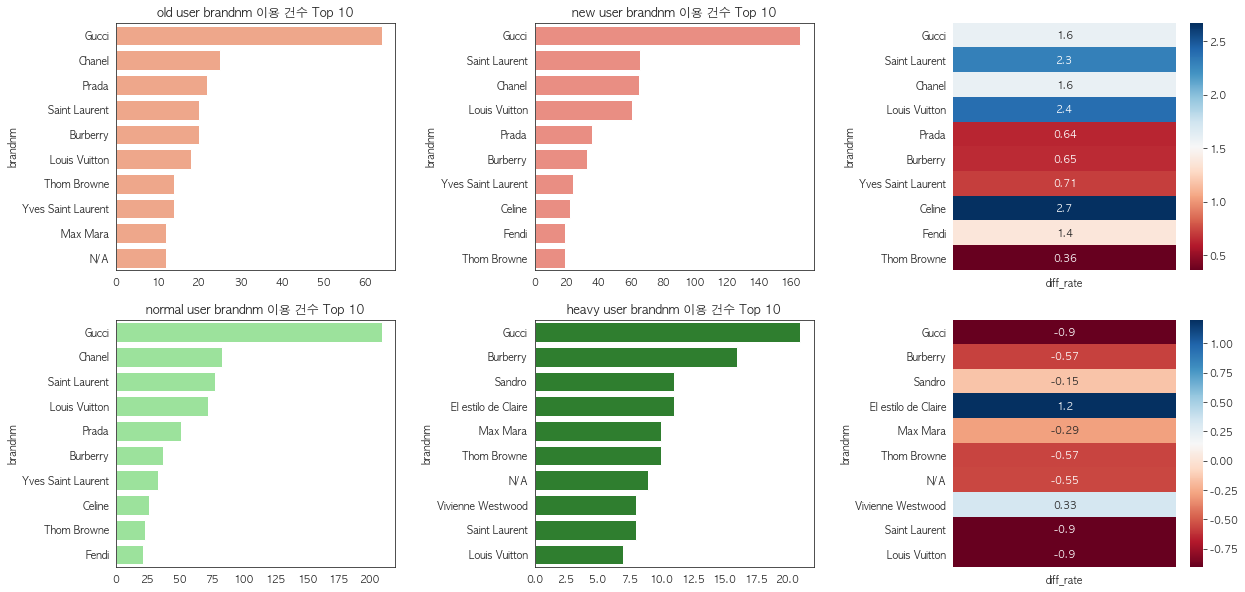

In [48]:
g_col = 'brandnm'

seg_list = ['seg_new', 'seg_heavy']
color_list = ['lightsalmon', 'salmon', 'lightgreen', 'forestgreen']
title_list = ['old user', 'new user', 'normal user', 'heavy user']

figure, ax_list_list = plt.subplots(nrows=2, ncols=3);
figure.set_size_inches(20,10)
ax_list = ax_list_list.reshape(2,3)

for i in [0,1]:

    sns.barplot(df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).values,
                df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).index,
                ax = ax_list[i, 0], color = color_list[(i*2)])
    ax_list[i, 0].set_title(f"{title_list[(i*2)]} {g_col} 이용 건수 Top 10")
 
    sns.barplot(df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).values,
                df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).index,
                ax = ax_list[i, 1], color = color_list[(i*2)+1])
    ax_list[i, 1].set_title(f"{title_list[(i*2)+1]} {g_col} 이용 건수 Top 10")
    
    diff_rate_oldnew = diff_rate(seg_list[i], 'diff_rate', g_col)

    sns.heatmap(diff_rate_oldnew, annot=True, ax = ax_list[i, 2], cmap="RdBu")
    
plt.subplots_adjust(wspace=0.5)

#### sub_type별 브랜드 이용 경향
- new user의 구매 건수가 old user의 구매 건수보다 전반적으로 약 3배 이상 높음을 알 수 있다.
- old user, new user 모두 가방(BA) 카테고리를 가장 많이 구매하는 것을 알 수 있다.
- old user는 가방을 포함해 카테고리 전반을 두루 이용하지만, new user는 가방 카테고리의 구매 건수가 매우 높다.<br>new user의 가방 구매 정도는 old user 대비 170% 상승했다.
----
- 구매 건수가 1건인 normal user는 가방 이용 비중이 전체의 50% 이상이지만,<br>구매 건수가 2건 이상인 heavy user는 의류 제품들을 구매한 것을 알 수 있다.
- heavy user는 normal user 대비 거의 90% 가까이 가방 구매가 줄고, 190% 하의 구매가 증가함을 알 수 있다.
----
***&#10145; user 대부분이 가방(BA) 구매를 위해 서비스를 이용하고 있으나, 여러 제품을 한번에 구매하는 user들은 의류 제품들을 주로 이용한다는 차이가 있다.***

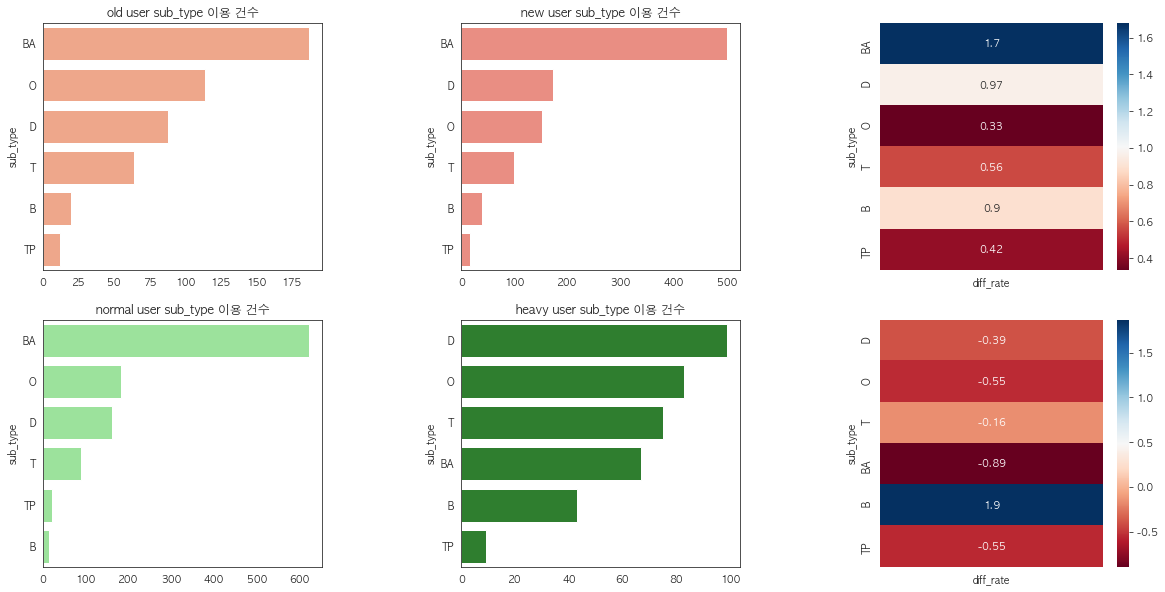

In [30]:
g_col = 'sub_type'

figure, ax_list_list = plt.subplots(nrows=2, ncols=3);
figure.set_size_inches(20,10)
ax_list = ax_list_list.reshape(2,3)

for i in [0,1]:

    sns.barplot(df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).values,
                df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).index,
                ax = ax_list[i, 0], color = color_list[(i*2)])
    ax_list[i, 0].set_title(f"{title_list[(i*2)]} {g_col} 이용 건수")
 
    sns.barplot(df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).values,
                df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).index,
                ax = ax_list[i, 1], color = color_list[(i*2)+1])
    ax_list[i, 1].set_title(f"{title_list[(i*2)+1]} {g_col} 이용 건수")
    
    diff_rate_oldnew = diff_rate(seg_list[i], 'diff_rate', g_col)

    sns.heatmap(diff_rate_oldnew, annot=True, ax = ax_list[i, 2], cmap="RdBu")
    
plt.subplots_adjust(wspace=0.5)

#### 제품 특징(색상)별 브랜드 이용 경향
- 전반적으로 검정 색상 제품 구매가 가장 많음을 알 수 있다.
- new user의 경우, old user보다 핑크 색상의 제품 구매가 많음을 알 수 있고,<br>
- heavy user의 경우, normal user의 구매가 적은 흰색 제품의 구매가 많음을 알 수 있다.
----
***&#10145; user들은 전반적으로 검정 제품의 구매를 선호한다.***

In [31]:
# 제품명 맨 끝의 색 정보 추출 
df_seg['color'] = df_seg['goodsnm'].str.split(' ').str[-1]

non_color = ['coat', 'bag', 'jumper', 'dress', 'fur-outer', '2','jacket',
             'top', 'small', 'cardigan', 'bag2', '4', 'skirts', 'slacks',
             'clutch', 'skirt', 'blouse', 'chain', 'backpack', '1', 'vest',
             'shirts', 'shirt', '53', 'body', 'pants', '52.', 'singlebreasted-coat',
             'shirt_1', 'embellishment', 'peplum-dress', 'dress_', 'MM',
             't-shirts', 'wrap-skirt', 'wrap-dress', 'breaker', 'sweater', 'Bag']

for i in np.arange(0, len(df_seg['color'])):
    
    if df_seg['color'][i] in non_color:
        df_seg['color'][i] = np.nan

df_seg['color'].head(5)

0        navy
1       black
2      purple
3    deeppink
4       white
Name: color, dtype: object

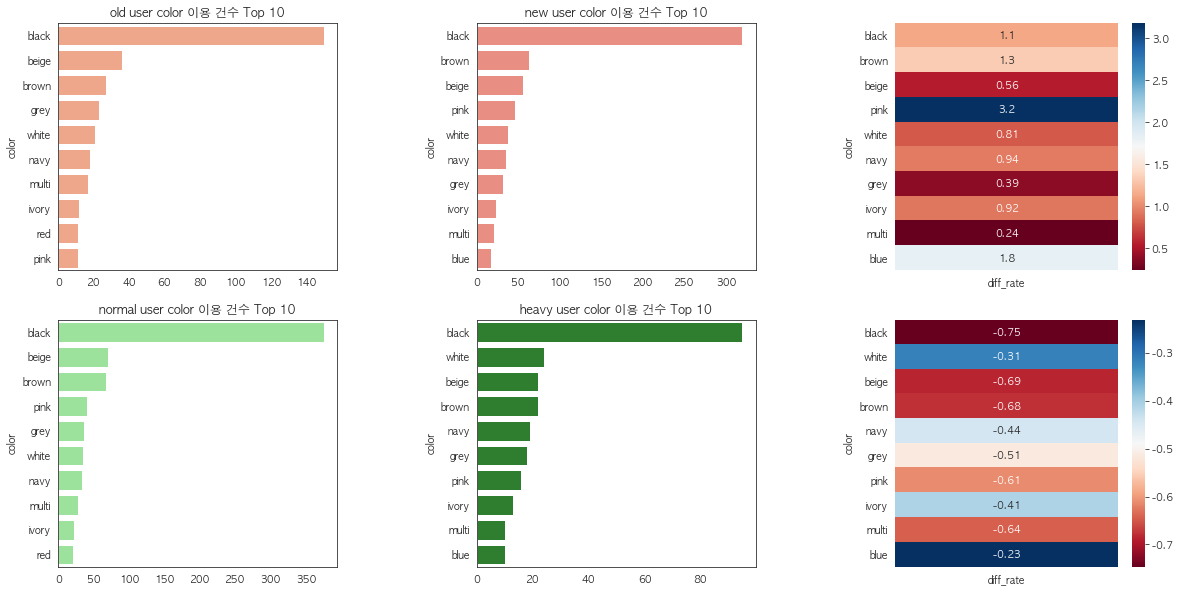

In [32]:
g_col = 'color'

figure, ax_list_list = plt.subplots(nrows=2, ncols=3);
figure.set_size_inches(20,10)
ax_list = ax_list_list.reshape(2,3)

for i in [0,1]:

    sns.barplot(df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).values,
                df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).index,
                ax = ax_list[i, 0], color = color_list[(i*2)])
    ax_list[i, 0].set_title(f"{title_list[(i*2)]} {g_col} 이용 건수 Top 10")
 
    sns.barplot(df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).values,
                df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().sort_values(ascending = False).head(10).index,
                ax = ax_list[i, 1], color = color_list[(i*2)+1])
    ax_list[i, 1].set_title(f"{title_list[(i*2)+1]} {g_col} 이용 건수 Top 10")
    
    diff_rate_oldnew = diff_rate(seg_list[i], 'diff_rate', g_col)

    sns.heatmap(diff_rate_oldnew, annot=True, ax = ax_list[i, 2], cmap="RdBu")
    
plt.subplots_adjust(wspace=0.5)

#### 앱 이용 및 이용권 별 브랜드 이용 경향
- 전체적으로 앱을 이용하는 user가 많고, 4days p_type 구매가 많다.
- new user는 비교적 앱을 이용하지 않는 user가 많다.<br>웹 이용 접근성도 쉬워졌는지 확인 필요

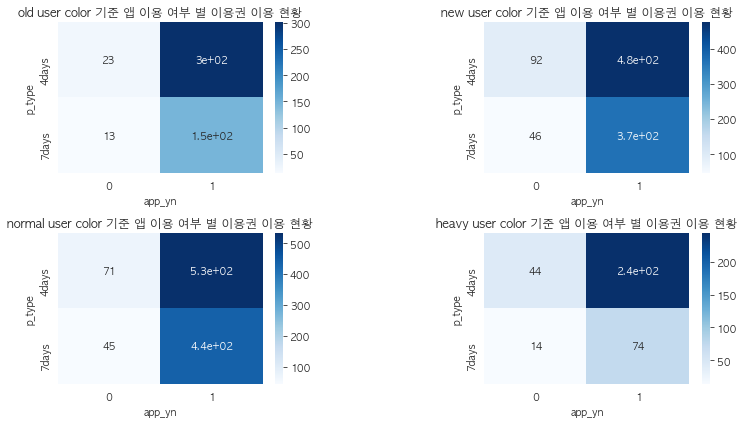

In [33]:
figure, ax_list_list = plt.subplots(nrows=2, ncols=2);
figure.set_size_inches(12,6)
ax_list = ax_list_list.reshape(2,2)

for i in [0,1]:
    
    sns.heatmap(
    pd.crosstab(index = df_seg.query(f"{seg_list[i]} == 0")['p_type'], columns = df_seg.query(f"{seg_list[i]} == 0")['app_yn']),
    cmap = 'Blues', annot=True, ax=ax_list[i, 0])
    ax_list[i, 0].set_title(f"{title_list[(i*2)]} {g_col} 기준 앱 이용 여부 별 이용권 이용 현황")

    sns.heatmap(
    pd.crosstab(index = df_seg.query(f"{seg_list[i]} == 1")['p_type'], columns = df_seg.query(f"{seg_list[i]} == 1")['app_yn']),
    cmap = 'Blues', annot=True, ax=ax_list[i, 1])
    ax_list[i, 1].set_title(f"{title_list[(i*2+1)]} {g_col} 기준 앱 이용 여부 별 이용권 이용 현황")

plt.subplots_adjust(left=1, right=3, wspace=10, hspace=3)
plt.tight_layout()

### 일자별 구매 건수 확인

#### df_seg 월별 주차 컬럼 추가

In [35]:
# 월별 주차 정보 생성
min_week = pd.DataFrame(df_seg.groupby('order_month')['order_week'].min()).reset_index('order_month').rename(columns={'order_week':'order_min_week'})
df_seg = pd.merge(df_seg, min_week, on='order_month', how='left').drop(columns=['order_week_y']).rename(columns={'order_week_x':'order_week'})
df_seg['order_week_num']=""

for i in np.arange(0,len(df_seg['order_date'])):
    if df_seg['order_week'][i] == df_seg['order_min_week'][i]:
        df_seg['order_week_num'][i] = 1
    elif df_seg['order_week'][i] == df_seg['order_min_week'][i]+1:
        df_seg['order_week_num'][i] = 2
    elif df_seg['order_week'][i] == df_seg['order_min_week'][i]+2:
        df_seg['order_week_num'][i] = 3
    elif df_seg['order_week'][i] == df_seg['order_min_week'][i]+3:
        df_seg['order_week_num'][i] = 4
    elif df_seg['order_week'][i] == df_seg['order_min_week'][i]+4:
        df_seg['order_week_num'][i] = 5

# 2021년 1월 1일~3일은 2020년 12월 5주차로 처리
df_seg['order_week_num'] = df_seg['order_week_num'].fillna(5)
df_seg.columns

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,...,BA,D,O,T,TP,seg_new,seg_heavy,color,order_min_week,order_week_num
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,0,2020,08,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,navy,1,
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,1,2020,04,...,0.00,2.00,1.00,0.00,0.00,0.00,1.00,black,1,
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,1,2020,04,...,0.00,2.00,1.00,0.00,0.00,0.00,1.00,purple,1,
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,1,2020,04,...,0.00,2.00,1.00,0.00,0.00,0.00,1.00,deeppink,1,
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,0,2020,12,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,white,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,A.P.C.,half round chain bag black,a129477,2019-06-13,2021-03-31,4days,BA,1,2019,06,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,black,9,5
1467,Louis Vuitton,monogram canvas clutch bag,a13741,2018-03-20,2021-03-31,4days,BA,1,2018,03,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,9,5
1468,Lucky Chouette,button check pattern shirts multi,a157459,2019-11-21,2021-03-31,4days,T,1,2019,11,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,multi,9,5
1469,Louis Vuitton,Mogram neonoe bucket brown bag,a174354,2020-01-16,2021-03-31,4days,BA,1,2020,01,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,9,5


#### 일자별 user 구매 추이 
- old user를 제외하고, 전체적으로 월별로 구매 건수 증가가 확인된다.
- 월별로 봤을 때 1,2주차보다 3,4주차에 구매 건수가 더 많음이 확인된다.
- 전체적으로 6주차(2월 8일~14일) 구매 건수가 급감한다.
- old user는 3주차, new user는 11~12주차 구매 건수가 급등함, normal user는 12주차 구매 건수가 급등한다,
- 주말보다 평일 구매 건수가 훨씬 많고, 특히 수요일 구매 건수가 많다.

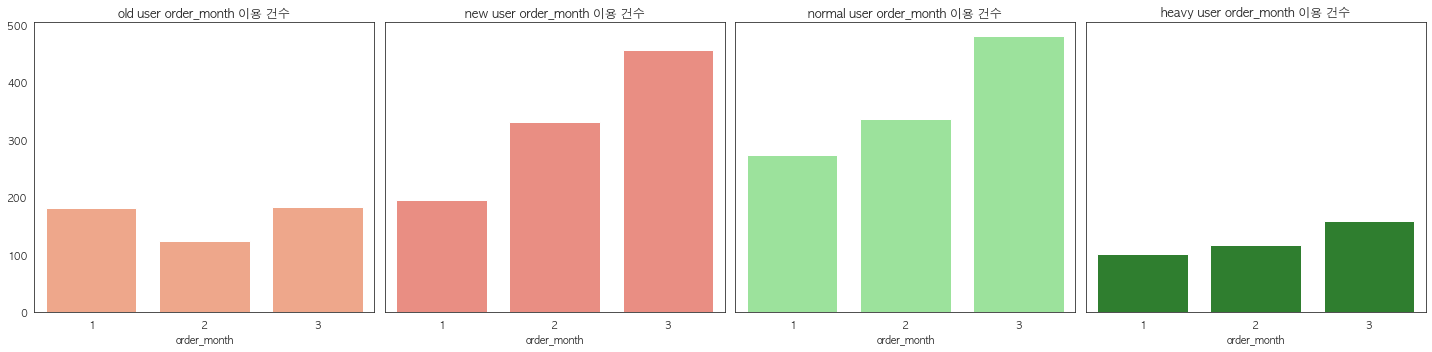

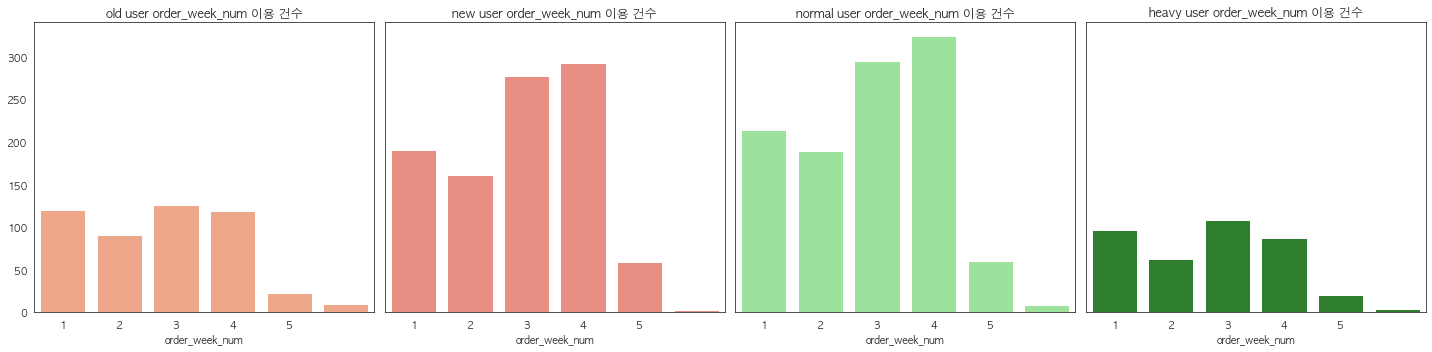

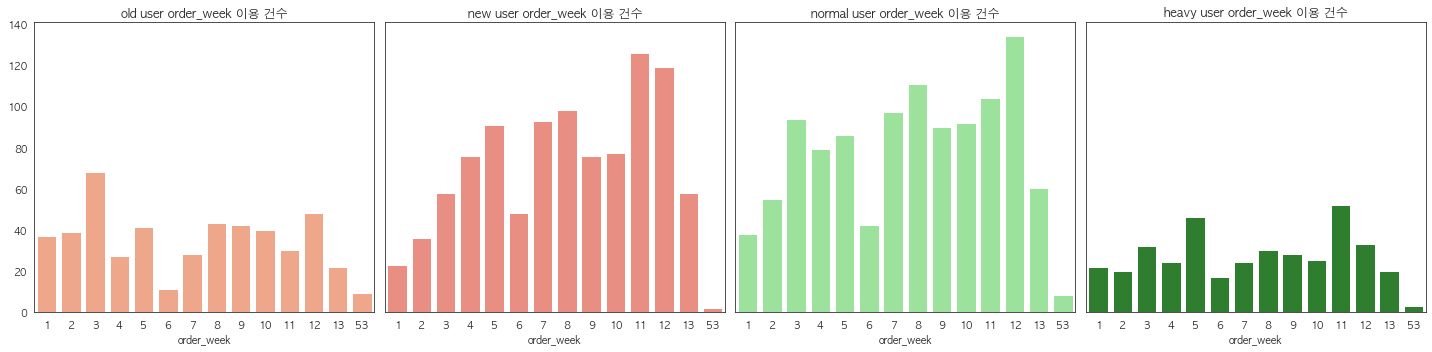

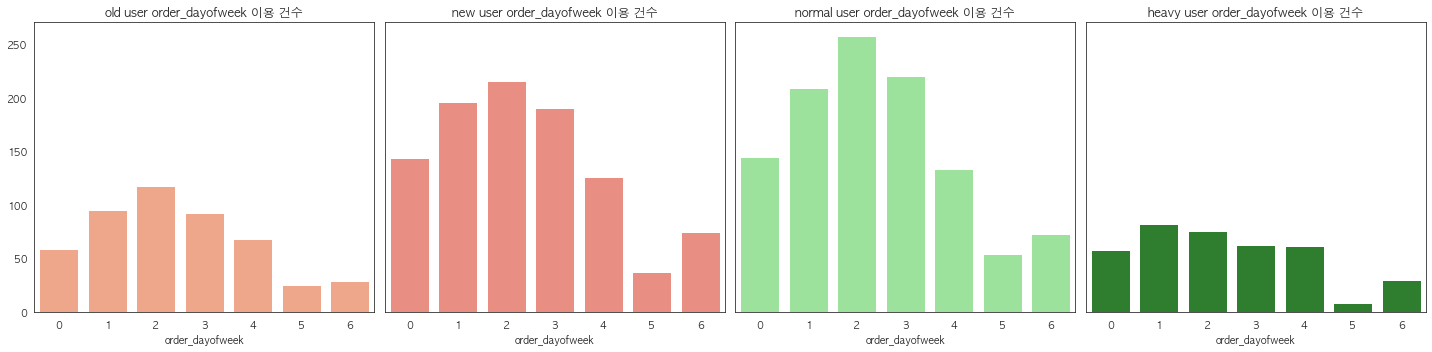

In [51]:
g_col = 'order_month'

figure, ax_list_list = plt.subplots(nrows=1, ncols=4, sharey=True);
figure.set_size_inches(20,5)
ax_list = ax_list_list.reshape(4)

for i in [0,1]:

    sns.barplot(df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)], color = color_list[(i*2)])
    ax_list[(i*2)].set_title(f"{title_list[(i*2)]} {g_col} 이용 건수")
 
    sns.barplot(df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)+1], color = color_list[(i*2)+1])
    ax_list[(i*2)+1].set_title(f"{title_list[(i*2)+1]} {g_col} 이용 건수")
 
plt.tight_layout()

g_col = 'order_week_num'

figure, ax_list_list = plt.subplots(nrows=1, ncols=4, sharey=True);
figure.set_size_inches(20,5)
ax_list = ax_list_list.reshape(4)

for i in [0,1]:

    sns.barplot(df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)], color = color_list[(i*2)])
    ax_list[(i*2)].set_title(f"{title_list[(i*2)]} {g_col} 이용 건수")
 
    sns.barplot(df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)+1], color = color_list[(i*2)+1])
    ax_list[(i*2)+1].set_title(f"{title_list[(i*2)+1]} {g_col} 이용 건수")
 
plt.tight_layout()

g_col = 'order_week'

figure, ax_list_list = plt.subplots(nrows=1, ncols=4, sharey=True);
figure.set_size_inches(20,5)
ax_list = ax_list_list.reshape(4)

for i in [0,1]:

    sns.barplot(df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)], color = color_list[(i*2)])
    ax_list[(i*2)].set_title(f"{title_list[(i*2)]} {g_col} 이용 건수")
 
    sns.barplot(df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)+1], color = color_list[(i*2)+1])
    ax_list[(i*2)+1].set_title(f"{title_list[(i*2)+1]} {g_col} 이용 건수")
 
plt.tight_layout()

g_col = 'order_dayofweek'

figure, ax_list_list = plt.subplots(nrows=1, ncols=4, sharey=True);
figure.set_size_inches(20,5)
ax_list = ax_list_list.reshape(4)

for i in [0,1]:

    sns.barplot(df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 0").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)], color = color_list[(i*2)])
    ax_list[(i*2)].set_title(f"{title_list[(i*2)]} {g_col} 이용 건수")
 
    sns.barplot(df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().index,
                df_seg.query(f"{seg_list[i]} == 1").groupby(g_col)['user'].count().values,
                ax = ax_list[(i*2)+1], color = color_list[(i*2)+1])
    ax_list[(i*2)+1].set_title(f"{title_list[(i*2)+1]} {g_col} 이용 건수")
 
plt.tight_layout()